# Gemini 3 with LangChain - Bootcamp

This notebook demonstrates all key features of Google's Gemini 3 model family using LangChain.

## Gemini 3 Overview

**Gemini 3 Pro** is Google's most intelligent model family, built on state-of-the-art reasoning capabilities.

### Key Features
- **Advanced Reasoning**: Dynamic thinking process with configurable thinking levels
- **1M Token Context**: Up to 1 million token input, 64k token output
- **Multimodal Excellence**: Images, PDFs, audio, video with granular resolution control
- **Knowledge Cutoff**: January 2025
- **Image Generation**: 4K resolution with grounded generation

### Model Variants

| Model | Context (In/Out) | Best For |
|-------|------------------|----------|
| `gemini-3-pro-preview` | 1M / 64k | Complex reasoning, coding, analysis |
| `gemini-3-pro-image-preview` | 65k / 32k | Image generation & editing |
| `gemini-2.5-flash` | 1M / 8k | Fast, cost-effective tasks |

### New Features in Gemini 3
1. **Thinking Level**: Control reasoning depth (`low` or `high`)
2. **Media Resolution**: Granular control per media type (`low`, `medium`, `high`, `ultra_high`)
3. **Temperature**: Keep at default 1.0 (changing can cause degraded performance)
4. **Thought Signatures**: Automatic reasoning context preservation

## Setup

Load environment variables for API authentication.

https://ai.google.dev/gemini-api/docs/pricing

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
# os.getenv("GOOGLE_API_KEY")

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

## Basic Usage

Demonstrates basic message formats and response structures for both Gemini 3 and 2.5 models.

In [5]:
gemini3 = 'gemini-3-pro-preview'
gemini2 = 'gemini-2.5-flash'

system_msg = SystemMessage("You are a helpful AI Assistant")
query = HumanMessage("Explain the theory of reletivity in the simple terms")

messages = [system_msg, query]

In [6]:
model = ChatGoogleGenerativeAI(model=gemini3)
response = model.invoke(messages)

In [12]:
# print(response.text)

response.content

[{'type': 'text',
  'text': 'Albert Einstein’s Theory of Relativity is actually two different theories packaged together: **Special Relativity** and **General Relativity**.\n\nHere is the simplest way to understand them without any confusing math.\n\n---\n\n### Part 1: Special Relativity (Speed and Time)\n\nImagine you are in a car traveling at 50 mph. You throw a ball forward at 10 mph.\n*   To **you**, the ball is moving at **10 mph**.\n*   To someone standing **on the sidewalk**, the ball is moving at **60 mph** (50 car + 10 ball).\n\nThis is how everything in the world works... **except light.**\n\nEinstein realized that light *always* travels at the same speed (about 670 million mph), no matter how fast you are moving. If you are in a rocket ship moving incredibly fast and you turn on a flashlight, the light beam leaves you at the same speed as if you were standing still.\n\nBecause the speed of light cannot change, Einstein realized that **time and space must change instead.**\n\

In [11]:
response.content_blocks

[{'type': 'text',
  'text': 'Albert Einstein’s Theory of Relativity is actually two different theories packaged together: **Special Relativity** and **General Relativity**.\n\nHere is the simplest way to understand them without any confusing math.\n\n---\n\n### Part 1: Special Relativity (Speed and Time)\n\nImagine you are in a car traveling at 50 mph. You throw a ball forward at 10 mph.\n*   To **you**, the ball is moving at **10 mph**.\n*   To someone standing **on the sidewalk**, the ball is moving at **60 mph** (50 car + 10 ball).\n\nThis is how everything in the world works... **except light.**\n\nEinstein realized that light *always* travels at the same speed (about 670 million mph), no matter how fast you are moving. If you are in a rocket ship moving incredibly fast and you turn on a flashlight, the light beam leaves you at the same speed as if you were standing still.\n\nBecause the speed of light cannot change, Einstein realized that **time and space must change instead.**\n\

In [13]:
model = ChatGoogleGenerativeAI(model=gemini2)
response = model.invoke(messages)

In [16]:
response.text
response.content
response.content_blocks

[{'type': 'text',
  'text': 'Okay, let\'s break down the theory of relativity in the simplest way possible, without math!\n\nEinstein\'s theory of relativity is actually two related theories: **Special Relativity** and **General Relativity**.\n\n---\n\n### Part 1: Special Relativity (1905)\n\nThis part deals with how space and time are connected for things moving at constant speeds.\n\n**The two main ideas are:**\n\n1.  **The speed of light is constant for everyone.**\n    *   Imagine you\'re on a train throwing a ball. If the train is moving at 50 mph and you throw the ball forward at 10 mph, someone on the ground sees the ball moving at 60 mph. (50 + 10)\n    *   Light doesn\'t work that way! If you shine a flashlight forward on that same 50 mph train, someone on the ground will *still* measure the light moving at exactly the speed of light (about 300,000 kilometers per second), not 50 mph faster.\n    *   This is the weird, fundamental rule: **Everyone, no matter how fast they\'re m

In [18]:
response.usage_metadata

{'input_tokens': 18,
 'output_tokens': 2793,
 'total_tokens': 2811,
 'input_token_details': {'cache_read': 0},
 'output_token_details': {'reasoning': 1627}}

In [19]:
response.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash',
 'safety_ratings': [],
 'model_provider': 'google_genai'}

## Streaming

Stream tokens in real-time as they're generated, improving user experience for long responses.

In [25]:
model = ChatGoogleGenerativeAI(model=gemini2)


In [26]:
query = "Explain the theory of relativity in the simple terms."

for chunk in model.stream(query):
    print(chunk.text, end="", flush=True)

    # break

Albert Einstein's theory of relativity is fundamentally about how space and time are not absolute but are relative to the observer, especially when dealing with very high speeds or very strong gravity.

Think of it in two main parts:

---

### Part 1: Special Relativity (About Speed)

This part deals with objects moving at a **constant speed** (not accelerating). It's built on two core ideas:

1.  **The laws of physics are the same for everyone moving at a constant speed.**
    *   Imagine you're on a train moving smoothly. If you drop a ball, it falls straight down. If you throw it in the air, it comes back to your hand. You can't tell you're moving just by doing experiments *inside* the train. The laws of physics work the same way as if you were standing still on the ground.

2.  **The speed of light in a vacuum (empty space) is always the same for everyone, no matter how fast they're moving.**
    *   This is the weirdest part! Imagine you're standing still and shine a flashlight. T

## Multimodal Capabilities

Process images, PDFs, audio, and video alongside text. Gemini 3 supports multiple input modalities with granular resolution control.

In [30]:
model = ChatGoogleGenerativeAI(model=gemini3)


human_msg = HumanMessage(
    [
        {'type': 'text', 'text': 'Describe the image provided'},
        {'type': 'image',
         'url': 'https://www.shutterstock.com/image-vector/vector-cute-baby-panda-cartoon-600nw-2427356853.jpg'}
    ]
)

response = model.invoke([system_msg, human_msg])

In [31]:
response

AIMessage(content=[{'type': 'text', 'text': 'Based on the image provided, here is a detailed description:\n\n**Subject and Pose**\nThe image features an adorable, cartoon-style giant panda sitting upright and facing directly forward. It has a classic "chibi" look with a large head relative to its body, emphasizing its cuteness.\n\n**Facial Features**\n*   **Eyes:** The panda has very large, expressive black eyes with white highlights (catchlights) that give them a shiny, wet look. They are framed by large, dark charcoal-grey eye patches. Small eyelashes are visible on the outer corners.\n*   **Ears:** Two round ears sit on top of the head. They are dark grey on the outside with bright pink inner shading.\n*   **Mouth and Nose:** It has a small, black button nose and a happy, open-mouthed smile that reveals a pink tongue.\n\n**Body Details**\n*   **Fur Pattern:** The panda follows the traditional coloring: a white face and belly, with dark charcoal-grey ears, eye patches, arms, and legs

In [33]:
print(response.text)

Based on the image provided, here is a detailed description:

**Subject and Pose**
The image features an adorable, cartoon-style giant panda sitting upright and facing directly forward. It has a classic "chibi" look with a large head relative to its body, emphasizing its cuteness.

**Facial Features**
*   **Eyes:** The panda has very large, expressive black eyes with white highlights (catchlights) that give them a shiny, wet look. They are framed by large, dark charcoal-grey eye patches. Small eyelashes are visible on the outer corners.
*   **Ears:** Two round ears sit on top of the head. They are dark grey on the outside with bright pink inner shading.
*   **Mouth and Nose:** It has a small, black button nose and a happy, open-mouthed smile that reveals a pink tongue.

**Body Details**
*   **Fur Pattern:** The panda follows the traditional coloring: a white face and belly, with dark charcoal-grey ears, eye patches, arms, and legs.
*   **Paws:** The panda is sitting with its rear feet 

### Image Analysis from Local File

Base64 encode local images, PDFs, or audio files for analysis.

In [36]:
import base64

mime_type = "image/png"

image_bytes = open("data/images/panda.png", 'rb').read()
bytes_base64 = base64.b64encode(image_bytes).decode('utf-8')

In [37]:
bytes_base64

'iVBORw0KGgoAAAANSUhEUgAAAlgAAAJYCAIAAAAxBA+LAAAQAElEQVR4AexdBYBdxdU+M3PlyWrchSDBg7u7eym0pbSlhQql1L39W+rUhXoLtKW0tMUh7u7uttlssm7P7r0j/zfvbTYJJJCEDUTecO7cuSNnzjkzc86cmZeFm2IoSqAogaIEihIoSuAwlgCnYihKoCiBogSKEihK4DCWQNEQHk6DX+S1KIGiBIoSKErgdRIoGsLXiaSYUZRAUQJFCRQlcDhJoGgID6fRLvJ6OEmgyGtRAkUJ7KEEioZwDwVVrFaUQFECRQkUJXBoSqBoCA/NcS1yVZRAUQKHkwSKvL4lCRQN4VsSX7FxUQJFCRQlUJTAwS6BoiE82EewSP9+kYAyebT52Bij81+FOJ8sRkUJFCVw6EjgIDOEh47gi5wc2BIQjKwtZGSMyUU5EFu0ghBCEYoSOCQlUDSEh+SwFpl6qxKA2TNGhxQ2tNVu3VpjyGCpKPVW0RbbFyVQlMABKAGs7gOQqiJJRQkQ0TspBA1LyE1kMrUN1UzYZSI1CfFOklTsuyiBogT2kwTsCt9PqItoixI4eCXgcOKkNQuqtq5PliWJGLM5VAxFCRQlcOhJoGgID70xLXLUBRIwCKRSYUtWpWNJHxhxOhoVz0YhiP0ERbRFCbxzEigawndO9sWeD2QJaMVI1dRtUix0uavIMGIHMr1F2ooSKEpgnyVQNIT7LLpiw0NYAtowDbu3aesm7nBGzGgtiNziJeEhPOZF1t5GCRxoXfEDjaAiPUUJHAgS4NzRRK3tbcmyUkPM4bCDyAAcCNQVaShKoCiBrpRA0RB2pTSLuA4NCcDcKQrbTWs2m6qoqMAiYYcGY0UuihIoSmBXEsAa31V2Ma9LJFBEcrBKQGtStc1bozDs0703UWGZFOKDlaUi3UUJFCWwOwkU1/buJFPMP3wlYAiGMKprqjHalMfKGXVYwsNXIkXOixI4pCVQNISH9PAWmds

In [38]:
model = ChatGoogleGenerativeAI(model=gemini2)


human_msg = HumanMessage(
    [
        {'type': 'text', 'text': 'Describe the image provided'},
        {'type': 'image',
         'base64': bytes_base64,
         "mime_type": mime_type}
    ]
)

response = model.invoke([system_msg, human_msg])

In [40]:
response.pretty_print()

================================== Ai Message ==================================

The image features a charming and brightly colored cartoon illustration of a baby panda sitting amidst lush green foliage on a white background.

The panda is the central focus, depicted in a classic black and white color scheme with a thick black outline. Its face is round and white, featuring large, expressive black eyes with prominent white gleams that give it a wide-eyed, innocent look. Around its eyes are the characteristic black patches. It has a small, oval black nose and a wide, friendly smile revealing a light pink tongue. Its round ears are black with soft pink inner ear details.

The panda's body is plump and round, with a white belly patch. Its arms and legs are black and chubby, and it is shown sitting upright with its front paws resting in front and its hind legs bent. The soles of its paws are visible, showing soft pink paw pads.

Surrounding the panda, particularly behind and to its sides,

### PDF Document Analysis

Extract and analyze content from PDF files. Recommended to use `media_resolution_medium` for PDFs.

In [43]:
## Reading media from local file and encoding to base64
## Now use smaller model for faster response

## image mime type example
# mime_type = "image/png", type = image

## pdf mime type example
# mime_type = "application/pdf", type = "file"

## audio mime type example
# mime_type = "audio/mpeg", type = "audio"

pdf_bytes = open(r'data\rag-data\apple\apple 10-q q1 2024.pdf', 'rb').read()
pdf_base64 = base64.b64encode(pdf_bytes).decode('utf-8')

mime_type = "application/pdf"


human_msg = HumanMessage(
    [
        {'type': 'text', 'text': 'summarize the key financial highlights from this quarterly report.'},
        {'type': 'file',
         'base64': pdf_base64,
         'mime_type': mime_type}
    ]
)


model = ChatGoogleGenerativeAI(model=gemini2)

In [44]:
response = model.invoke([system_msg, human_msg])

In [46]:
print(response.text)

Here are the key financial highlights from Apple Inc.'s quarterly report for the period ended March 30, 2024, compared to the same period last year (April 1, 2023):

**For the Three Months Ended March 30, 2024 (Q2 FY2024 vs. Q2 FY2023):**

*   **Total Net Sales Decreased:** Net sales were **$90.75 billion**, down 4.3% from $94.84 billion.
    *   **Product Sales Declined:** Products net sales were **$66.89 billion**, a 9.5% decrease from $73.93 billion.
        *   **iPhone Sales Down:** iPhone net sales decreased by 10% to $45.96 billion.
        *   **iPad Sales Down Significantly:** iPad net sales fell 17% to $5.56 billion.
        *   **Wearables, Home & Accessories Sales Down:** This category saw a 10% decrease to $7.91 billion.
        *   **Mac Sales Increased:** Mac net sales were a bright spot, increasing 4% to $7.45 billion.
    *   **Services Sales Grew Strongly:** Services net sales continued their robust growth, increasing 14% to **$23.87 billion**.
*   **Gross Margin Incr

In [47]:
response.usage_metadata

{'input_tokens': 7242,
 'output_tokens': 3481,
 'total_tokens': 10723,
 'input_token_details': {'cache_read': 0},
 'output_token_details': {'reasoning': 2421}}

## Tool Calling (Function Calling)

Bind custom tools to the model for extended capabilities like web search or API calls.

In [59]:
from scripts import base_tools

In [60]:
response = base_tools.web_search.invoke({'query': "what is the latest stock news"})

In [61]:
response

[WebSearchResult(content='India Business News | India Stock Market, Sensex, Business &amp; Financial News - Times of India\nEdition\nIN\n* [IN](https://timesofindia.indiatimes.com/)\n* [US](https://timesofindia.indiatimes.com/us)\nEnglish\n* [English](https://timesofindia.indiatimes.com/)\n* [हिन्दी](https://navbharattimes.indiatimes.com/)\n* [मराठी](https://marathi.indiatimes.com/)\n* [ಕನ್ನಡ](https://vijaykarnataka.com/)\n* [தமிழ்](https://tamil.samayam.com/)\n* [বাংলা](https://bangla.indiatimes.com/)\n* [മലയാളം](https://malayalam.samayam.com/)\n* [తెలుగు](https://telugu.samayam.com/)\n* [ગુજરાતી](https://www.iamgujarat.com/)\n**\n[Weather](https://timesofindia.indiatimes.com/weather)\nSign In\n[![](https://static.toiimg.com/photo/79638690.cms)](https://timesofindia.indiatimes.com/)\n## [TOI](https://timesofindia.indiatimes.com)\n* [News](https://timesofindia.indiatimes.com/)\n* [Business](https://timesofindia.indiatimes.com/business)\n* [India Business](https://timesofindia.indiatime

In [62]:
response = base_tools.get_weather.invoke({'location': 'Mumbai'})

In [64]:
model = ChatGoogleGenerativeAI(model=gemini2)

model_with_tools = model.bind_tools([base_tools.web_search, base_tools.get_weather])

In [65]:
model_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000020A9A61EC50>, default_metadata=(), model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'web_search', 'description': 'Perform a live web search using Ollama Cloud Web Search API.\n\nInput:\n    query: search query string\n\nOutput:\n    JSON string of top results (max_results=2).', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query

In [66]:
response = model_with_tools.invoke("What is the weather in mumbai? and What is the US stock news today?")

In [67]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "US stock news today"}'}, '__gemini_function_call_thought_signatures__': {'876d1d2f-c05b-4e3b-8d1e-7bd7ce0d6ebf': 'CqgCAXLI2nwd4XCO2Img9mTCoOX8bVRR5ii7VchEQBKj4hqzFFKRYobz1OXK1p1wz+PWd/85vWv1BYzSVwScauSmF5sQznAuu6vxafkUKkpFotPYL3XAa553PwV+qDeJDDsxawpdRS84l6uCn7c/DpjFbpb0IVC4mYItqCg+FOHkzjKfweWFq6bbj3clii66z30KxUBuC9HaAll/JW2oH10IFtFrEj0EUNH0KWpOq/H8kl+d4A41Nwd9CKazzP4E/9UCjJJjZNbDqiKwhwSZZaMRk8Om0S7T8OdfW2aQ5D4k4NO9mDs485Si449ImNvkDPg1I5L3PvmXZjnvoywO/PkV9Qk9xhFFDAPhmzWsAVuTUu5XqtLPL1U4q0TDQjsRsIJVvm2Ef4MVmFY='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--052027fc-31e7-4d76-b9db-2ddf90c019fa-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': '876d1d2f-c05b-4e3b-8d1e-7bd7ce0d6ebf', 'type': 'to

## Thinking Support (Reasoning)

Configure the model's reasoning depth with `thinking_budget` or `thinking_level`. 

**Gemini 3 Recommendation**: Use `thinking_level="high"` (default) for complex tasks, `"low"` for simple tasks.

**Documentation**: https://ai.google.dev/gemini-api/docs/thinking

Control reasoning depth:
- `thinking_budget`: Legacy parameter (number of tokens)
- `thinking_level`: New parameter (`"low"` or `"high"`)
- `include_thoughts`: Show reasoning process in response

In [84]:
model = ChatGoogleGenerativeAI(model=gemini2,
                               thinking_budget=100,
                               include_thoughts=True)

In [86]:
response = model.invoke(query)

In [88]:
response.content_blocks

[{'type': 'reasoning',
  'reasoning': "**Relativity in Plain English**\n\nOkay, so I need to explain the theory of relativity, and the prompt says to keep it simple, which I appreciate. Forget the equations, the tensors, the whole shebang - let's focus on the *concepts*.\n\nFirst, let's clarify that it's actually **two** theories, not just one. Special Relativity and General Relativity. We're talking Einstein here, obviously.\n\nNow, the crucial point, the thing that blows everything else out of the water, is that space and time aren't these fixed, absolute things. They're interconnected, they're relative, and they're *malleable*. That's the core.  This should be enough to start with - it's the foundation we can build on.\n"},
 {'type': 'text',
  'text': 'Okay, let\'s break down the theory of relativity in the simplest terms possible, without getting bogged down in complex math.\n\nForget what you *think* you know about space and time being fixed and unchangeable. Einstein\'s theory ba

In [89]:
response.usage_metadata

{'input_tokens': 11,
 'output_tokens': 1312,
 'total_tokens': 1323,
 'input_token_details': {'cache_read': 0},
 'output_token_details': {'reasoning': 98}}

In [90]:
model = ChatGoogleGenerativeAI(model=gemini2,
                               thinking_budget=0,
                               include_thoughts=True)

response = model.invoke(query)
response.usage_metadata

{'input_tokens': 11,
 'output_tokens': 856,
 'total_tokens': 867,
 'input_token_details': {'cache_read': 0}}

## Built-in Tools

Google Gemini provides native tools: Google Search and Code Execution. These require no additional setup.

Google Gemini supports a variety of built-in tools, which can be bound to the model in the usual way.

In [91]:
model = ChatGoogleGenerativeAI(model=gemini2)

model_with_tools = model.bind_tools([{'google_search': {}}, {'code_execution': {}}])

In [97]:
response = model_with_tools.invoke(query)

In [98]:
response.content_blocks

[{'type': 'text',
  'text': 'The theory of relativity, developed by Albert Einstein, is actually two interconnected theories: **Special Relativity** and **General Relativity**. Both fundamentally changed our understanding of space, time, gravity, and the universe.\n\nLet\'s break them down in simple terms:\n\n### 1. Special Relativity (1905)\n\nThis theory deals with how space and time are relative for observers who are moving at constant speeds relative to each other. It\'s built on two core ideas:\n\n*   **The laws of physics are the same for everyone in steady motion.** Imagine you\'re on a train moving smoothly; if you drop a ball, it falls straight down, just like it would if the train were stopped. The laws of physics don\'t change just because you\'re moving.\n*   **The speed of light is constant for everyone, no matter how fast they\'re moving or how fast the light source is moving.** This is the really mind-bending one. If you shine a flashlight while standing still, the light

In [100]:
query = "When is the next total solar eclipse in the US and what is 3 + 2?"
response = model_with_tools.invoke(query)

c:\Users\laxmi\anaconda3\envs\ml\Lib\site-packages\langchain_google_genai\chat_models.py:1052: UserWarning: 
        - 'executable_code': Always present.
        - 'execution_result' & 'image_url': May be absent for some queries.

        Validate before using in production.

  warnings.warn(


In [103]:
print(response.text)

The answer to 3 + 2 is 5.

For the total solar eclipse question, I will use the search tool.The next total solar eclipse in the US will be on **March 30, 2033**, visible only in Alaska.

The next total solar eclipse visible in the contiguous United States will be on **August 23, 2044**, crossing parts of Montana, North Dakota, and South Dakota. Another significant total solar eclipse will occur on **August 12, 2045**, with a path stretching from California to Florida.


In [104]:
response.content_blocks

[{'type': 'text',
  'text': 'The answer to 3 + 2 is 5.\n\nFor the total solar eclipse question, I will use the search tool.'},
 {'type': 'server_tool_call',
  'name': 'code_interpreter',
  'args': {'code': 'concise_search("next total solar eclipse in US")\n',
   'language': <Language.PYTHON: 1>},
  'id': '5e69fd45-e4d7-44d5-b492-0eff5ee30850'},
 {'type': 'server_tool_result',
  'tool_call_id': '',
  'status': 'success',
  'output': 'Looking up information on Google Search.\n',
  'extras': {'block_type': 'code_execution_result',
   'outcome': <Outcome.OUTCOME_OK: 1>}},
 {'type': 'text',
  'text': 'The next total solar eclipse in the US will be on **March 30, 2033**, visible only in Alaska.\n\nThe next total solar eclipse visible in the contiguous United States will be on **August 23, 2044**, crossing parts of Montana, North Dakota, and South Dakota. Another significant total solar eclipse will occur on **August 12, 2045**, with a path stretching from California to Florida.'}]

## Context Caching

Cache large documents to reduce costs and latency for repeated queries. Minimum 2,048 tokens required.

**Benefits**:
- Reduced API costs
- Faster response times
- Ideal for analyzing large documents repeatedly

**Resources**:
- [Caching Guide](https://ai.google.dev/gemini-api/docs/caching?hl=en&lang=python#pdfs_1)
- [Pricing Details](https://ai.google.dev/gemini-api/docs/pricing)

In [105]:
import time
from google import genai
from google.genai.types import CreateCachedContentConfig, Content, Part

In [106]:
client =genai.Client()

In [107]:
client

### Initialize Client and Upload Files

In [108]:
file_paths = [
    "data/rag-data/apple/apple 10-q q1 2024.pdf",
    "data/rag-data/apple/apple 10-q q2 2024.pdf"
]

uploaded_files = []
for path in file_paths:
    file = client.files.upload(file=path)
    while file.state.name == "PROCESSING":
        time.sleep(2)
        file = client.files.get(name=file.name)

    uploaded_files.append(file)

In [111]:
uploaded_files

[File(
   create_time=datetime.datetime(2025, 12, 8, 12, 17, 32, 424153, tzinfo=TzInfo(0)),
   expiration_time=datetime.datetime(2025, 12, 10, 12, 17, 30, 985824, tzinfo=TzInfo(0)),
   mime_type='application/pdf',
   name='files/sehbdiq7qzh8',
   sha256_hash='YjE5YjFmMTc2YzVjZWFmOWU2ZWE1MjkwNzAxMzQ4MGViMTc3MTY5NjIzNTFmOGZkZmUwYWQ0YjEzYmIzM2VkMA==',
   size_bytes=280756,
   source=<FileSource.UPLOADED: 'UPLOADED'>,
   state=<FileState.ACTIVE: 'ACTIVE'>,
   update_time=datetime.datetime(2025, 12, 8, 12, 17, 32, 424153, tzinfo=TzInfo(0)),
   uri='https://generativelanguage.googleapis.com/v1beta/files/sehbdiq7qzh8'
 ),
 File(
   create_time=datetime.datetime(2025, 12, 8, 12, 17, 35, 17962, tzinfo=TzInfo(0)),
   expiration_time=datetime.datetime(2025, 12, 10, 12, 17, 34, 236373, tzinfo=TzInfo(0)),
   mime_type='application/pdf',
   name='files/1an9dktevst9',
   sha256_hash='ZDY1YzAyMDM0NThlZjRkZGQ1ZDgwZjU1ZTZjNjVhOTkyODBjNzQzOWI3OTJiZTNiNTkyNDU5ZjRhYmFmN2RhNw==',
   size_bytes=333438,
   so

### Create Cache

Cache content for 1800 seconds (30 minutes) with system instructions.

In [112]:
parts = []
for f in uploaded_files:
    part = Part.from_uri(file_uri=f.uri, mime_type=f.mime_type)
    parts.append(part)

contents = [Content(role='user', parts=parts)]

In [114]:
# contents

In [115]:
cache = client.caches.create(
    model=gemini2,
    config=CreateCachedContentConfig(
        display_name = 'Apple Q1 Q2 2024 reports',
        system_instruction="You are a financial analyst. Use these Apple quarterly reports to answer questions.",
        contents=contents,
        ttl='1800s'
    )
)

In [116]:
cache

CachedContent(
  create_time=datetime.datetime(2025, 12, 8, 12, 23, 13, 833004, tzinfo=TzInfo(0)),
  display_name='Apple Q1 Q2 2024 reports',
  expire_time=datetime.datetime(2025, 12, 8, 12, 53, 12, 583492, tzinfo=TzInfo(0)),
  model='models/gemini-2.5-flash',
  name='cachedContents/wz1zpdjhvvlpv983nfekvyinsn5m6anlqn6xecir',
  update_time=datetime.datetime(2025, 12, 8, 12, 23, 13, 833004, tzinfo=TzInfo(0)),
  usage_metadata=CachedContentUsageMetadata(
    total_token_count=14465
  )
)

### Query with Cached Content

First query - cache is created and tokens are counted.

In [117]:
model = ChatGoogleGenerativeAI(
    model=gemini2,
    cached_content = cache.name
)

In [118]:
query = "Compare the revenue growth between Q1 and Q2 2024."
response = model.invoke(query)

In [120]:
response.usage_metadata

{'input_tokens': 14482,
 'output_tokens': 2225,
 'total_tokens': 16707,
 'input_token_details': {'cache_read': 14465},
 'output_token_details': {'reasoning': 1644}}

In [119]:
from IPython.display import Markdown, display
display(Markdown(response.text))

Based on the provided Apple quarterly reports:

**For the quarter ended March 30, 2024 (Apple's fiscal Q2 2024):**

*   Total net sales for the quarter ended March 30, 2024: **$90,753 million** (Page 4, Q2 2024 Form 10-Q)
*   Total net sales for the quarter ended April 1, 2023: **$94,836 million** (Page 4, Q2 2024 Form 10-Q)
*   **Revenue growth (year-over-year) for the quarter ended March 30, 2024:**
    $(90,753 - 94,836) / 94,836 = -0.04305 \approx \textbf{-4.31%}$

**For the quarter ended June 29, 2024 (Apple's fiscal Q3 2024):**

*   Total net sales for the quarter ended June 29, 2024: **$85,777 million** (Page 4, Q3 2024 Form 10-Q)
*   Total net sales for the quarter ended July 1, 2023: **$81,797 million** (Page 4, Q3 2024 Form 10-Q)
*   **Revenue growth (year-over-year) for the quarter ended June 29, 2024:**
    $(85,777 - 81,797) / 81,797 = 0.04866 \approx \textbf{4.87%}$

**Comparison of Revenue Growth:**

*   Revenue for the quarter ended March 30, 2024 (Apple's fiscal Q2 2024) **decreased by 4.31%** compared to the same quarter in the prior year.
*   Revenue for the quarter ended June 29, 2024 (Apple's fiscal Q3 2024) **increased by 4.87%** compared to the same quarter in the prior year.

In summary, Apple experienced a year-over-year revenue decline in the quarter ending March 30, 2024, but saw a return to year-over-year revenue growth in the subsequent quarter ending June 29, 2024.

### Reuse Cache for Second Query

Notice `cache_read` tokens in usage metadata - shows cache is being used.

In [121]:
query = "Provide a detailed analysis of Apple's Q1 and Q2 2024 earnings with key financial metrics, revenue comparison, and growth trends. Format this as bullet points suitable for an infographic."
response = model.invoke(query)

In [122]:
print(response.text)

Here's a detailed analysis of Apple's Q1 and Q2 2024 earnings, formatted as bullet points suitable for an infographic.

**Important Note:** Apple's fiscal Q1 2024 covers October-December 2023, and fiscal Q2 2024 covers January-March 2024. The Q1 2024 figures below are **derived** by subtracting the Q2 2024 (three-month) data from the YTD Q1+Q2 2024 (six-month) data provided in the Q2 2024 report.

---

### **Apple Q1 2024 Earnings (Derived: October 2023 - December 2023)**

*   **Total Net Sales:**
    *   **$119.6 Billion** (vs. $117.2 Billion in Q1 2023)
    *   **Growth:** +2.1% Year-over-Year
*   **Net Income:**
    *   **$33.9 Billion** (vs. $30.0 Billion in Q1 2023)
    *   **Growth:** +13.1% Year-over-Year
*   **Estimated Diluted Earnings Per Share (EPS):**
    *   **~$2.18** (vs. ~$1.88 in Q1 2023) - *Derived from net income and approximate weighted-average shares*
*   **Revenue Breakdown (Q1 2024 vs. Q1 2023):**
    *   **iPhone:** $69.7 Billion (up 5.9%)
    *   **Services:** 

In [123]:
response.usage_metadata

{'input_tokens': 14507,
 'output_tokens': 6737,
 'total_tokens': 21244,
 'input_token_details': {'cache_read': 14465},
 'output_token_details': {'reasoning': 5588}}

## Image Generation

Generate high-quality images up to 4K resolution using `gemini-3-pro-image-preview`.

**Features**:
- Text rendering in images
- Multiple aspect ratios
- Grounded generation with Google Search
- Conversational editing

```
# Available aspect ratios
aspect_ratios = ["1:1", "2:3", "3:2", "3:4", "4:3", "4:5", "5:4", "9:16", "16:9", "21:9"]

# Available resolutions
resolutions = ["1K", "2K", "4K"]
```

https://github.com/langchain-ai/langchain-google/issues/1235

In [132]:
from langchain_google_genai import Modality
from IPython.display import Image
aspect_ratio = "16:9"
resolution = "1K"

In [127]:
image_model = ChatGoogleGenerativeAI(model="gemini-3-pro-image-preview")

image_content = f"Create a professional infographic with this data:\n\n{response.text}"

image_response = image_model.invoke(
    image_content, response_modalities=[Modality.TEXT, Modality.IMAGE]
)

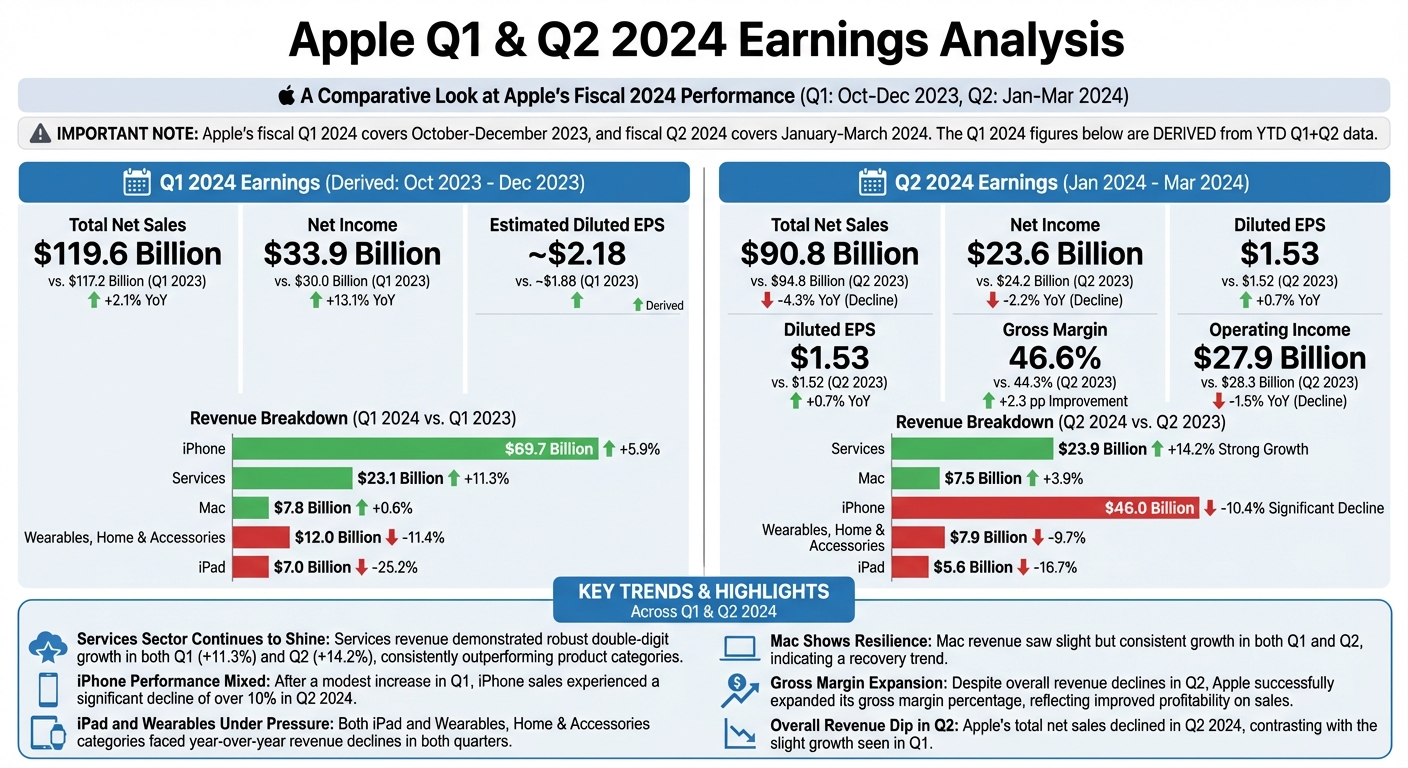

In [134]:
display(Image(base64.b64decode(image_response.content_blocks[0]['base64'])))

In [135]:
with open("data/images/apple_info.png", 'wb') as f:
    f.write(base64.b64decode(image_response.content_blocks[0]['base64']))